# Poisson equation

This demo is implemented in {download}`demo_poisson.py`. It
illustrates how to:

- Create a {py:class}`function space <dolfinx.fem.FunctionSpace>`
- Solve a linear partial differential equation

## Equation and problem definition

For a domain $\Omega \subset \mathbb{R}^n$ with boundary $\partial
\Omega = \Gamma_{D} \cup \Gamma_{N}$, the Poisson equation with
particular boundary conditions reads:

$$
\begin{align}
  - \nabla^{2} u &= f \quad {\rm in} \ \Omega, \\
  u &= 0 \quad {\rm on} \ \Gamma_{D}, \\
  \nabla u \cdot n &= g \quad {\rm on} \ \Gamma_{N}. \\
\end{align}
$$

where $f$ and $g$ are input data and $n$ denotes the outward directed
boundary normal. The variational problem reads: find $u \in V$ such
that

$$
a(u, v) = L(v) \quad \forall \ v \in V,
$$

where $V$ is a suitable function space and

$$
\begin{align}
  a(u, v) &:= \int_{\Omega} \nabla u \cdot \nabla v \, {\rm d} x, \\
  L(v)    &:= \int_{\Omega} f v \, {\rm d} x + \int_{\Gamma_{N}} g v \, {\rm d} s.
\end{align}
$$

The expression $a(u, v)$ is the bilinear form and $L(v)$
is the linear form. It is assumed that all functions in $V$
satisfy the Dirichlet boundary conditions ($u = 0 \ {\rm on} \
\Gamma_{D}$).

In this demo we consider:

- $\Omega = [0,2] \times [0,1]$ (a rectangle)
- $\Gamma_{D} = \{(0, y) \cup (2, y) \subset \partial \Omega\}$
- $\Gamma_{N} = \{(x, 0) \cup (x, 1) \subset \partial \Omega\}$
- $g = \sin(5x)$
- $f = 10\exp(-((x - 0.5)^2 + (y - 0.5)^2) / 0.02)$

## Implementation

The modules that will be used are imported:

In [1]:
from mpi4py import MPI
from petsc4py.PETSc import ScalarType  # type: ignore

In [2]:
import numpy as np

import ufl
from dolfinx import fem, io, mesh, plot
from dolfinx.fem.petsc import LinearProblem
from ufl import ds, dx, grad, inner


Note that it is important to first `from mpi4py import MPI` to
ensure that MPI is correctly initialised.

We create a rectangular {py:class}`Mesh <dolfinx.mesh.Mesh>` using
{py:func}`create_rectangle <dolfinx.mesh.create_rectangle>`, and
create a finite element {py:class}`function space
<dolfinx.fem.FunctionSpace>` $V$ on the mesh.

In [3]:
msh = mesh.create_rectangle(
    comm=MPI.COMM_WORLD,
    points=((0.0, 0.0), (2.0, 1.0)),
    n=(32, 16),
    cell_type=mesh.CellType.triangle,
)
V = fem.functionspace(msh, ("Lagrange", 1))

The second argument to {py:func}`functionspace
<dolfinx.fem.functionspace>` is a tuple `(family, degree)`, where
`family` is the finite element family, and `degree` specifies the
polynomial degree. In this case `V` is a space of continuous Lagrange
finite elements of degree 1.

To apply the Dirichlet boundary conditions, we find the mesh facets
(entities of topological co-dimension 1) that lie on the boundary
$\Gamma_D$ using {py:func}`locate_entities_boundary
<dolfinx.mesh.locate_entities_boundary>`. The function is provided
with a 'marker' function that returns `True` for points `x` on the
boundary and `False` otherwise.

In [5]:
facets = mesh.locate_entities_boundary(
    msh,
    dim=(msh.topology.dim - 1),
    marker=lambda x: np.isclose(x[0], 0.0) | np.isclose(x[0], 2.0),
)

We now find the degrees-of-freedom that are associated with the
boundary facets using {py:func}`locate_dofs_topological
<dolfinx.fem.locate_dofs_topological>`:

In [6]:
dofs = fem.locate_dofs_topological(V=V, entity_dim=1, entities=facets)

and use {py:func}`dirichletbc <dolfinx.fem.dirichletbc>` to create a
{py:class}`DirichletBC <dolfinx.fem.DirichletBC>` class that
represents the boundary condition:

In [7]:
bc = fem.dirichletbc(value=ScalarType(0), dofs=dofs, V=V)

Next, the variational problem is defined:

In [8]:
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
x = ufl.SpatialCoordinate(msh)
f = 10 * ufl.exp(-((x[0] - 0.5) ** 2 + (x[1] - 0.5) ** 2) / 0.02)
g = ufl.sin(5 * x[0])
a = inner(grad(u), grad(v)) * dx
L = inner(f, v) * dx + inner(g, v) * ds

A {py:class}`LinearProblem <dolfinx.fem.petsc.LinearProblem>` object is
created that brings together the variational problem, the Dirichlet
boundary condition, and which specifies the linear solver. In this
case an LU solver is used. The {py:func}`solve
<dolfinx.fem.petsc.LinearProblem.solve>` computes the solution.

In [9]:
problem = LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})

uh = problem.solve()

The solution can be written to a {py:class}`XDMFFile
<dolfinx.io.XDMFFile>` file visualization with ParaView or VisIt:

In [10]:
with io.VTKFile(msh.comm, "out_poisson/poisson.vtk", "w") as file:
    file.write_mesh(msh)
    file.write_function(uh)

and displayed using [pyvista](https://docs.pyvista.org/).

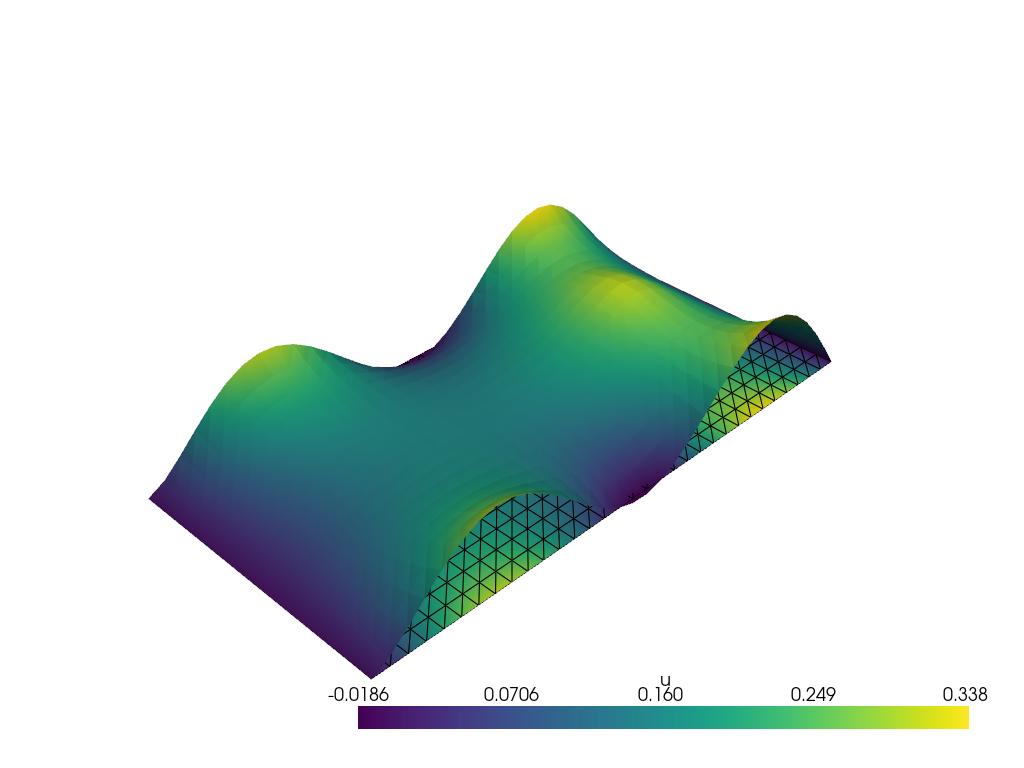

In [17]:
import pyvista

# To remove interactivity in the plots, use
# pyvista.set_jupyter_backend('static')

cells, types, x = plot.vtk_mesh(V)
grid = pyvista.UnstructuredGrid(cells, types, x)
grid.point_data["u"] = uh.x.array.real
grid.set_active_scalars("u")
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
warped = grid.warp_by_scalar()
plotter.add_mesh(warped)
if pyvista.OFF_SCREEN:
    pyvista.start_xvfb(wait=0.1)
    plotter.screenshot("uh_poisson.png")
else:
    plotter.show()
